<center><h2>Gaussian Mixture Models (GMM) </h2></center>

<center><img src="images/paranormal.jpg" width="55%"/></center>

By The End Of This Session You Should Be Able To:
----

- Describe the Gaussian Distribution
- Explain how Gaussian Mixture Models (GMM) are a logical extension
- Apply EM to fit a GMM to real data

Normal Distribution: A Pretty Picture
------
<center><img src="images/normal.png" width="70%"/></center>

What are the Features & Benefits of a Normal Distribution?
------


- Has mean & variance/standard deviation, ~$N(\mu, \sigma^2)$
- Function is well known
- Most of the mass is in the middle
- Symmetrical
- Goes from -∞ to ∞

Normal Distribution: In Code
------


In [46]:
reset -fs

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn

import warnings
warnings.filterwarnings('ignore')

palette = "Dark2"
%matplotlib inline

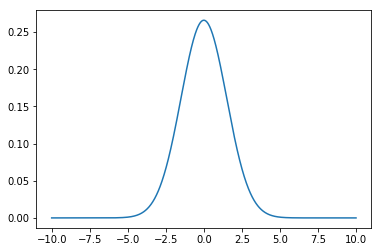

In [48]:
x = np.linspace(start=-10, stop=10, num=1000)
y = scipy.stats.norm.pdf(x, loc=0, scale=1.5) 
plt.plot(x, y);

Discussion: What are example of data you can model with a normal distribution?
-----

- Physical quantities (height, weight, length, ...)  
- Test scores  
- Salary  
- Anything that is sum of many independent processes. This is the heart of the Central Limit Theorem (CLT).  


<center><h2>Not All data can be modeled with a single Gaussian</h2></center>

<center><img src="images/abnormal.png" width="70%"/></center>

<center><h2>Sometimes There Are 2 Gaussians</h2></center>

<center><img src="images/2_gaus.png" width="70%"/></center>

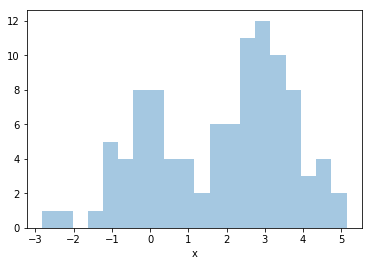

In [49]:
df = pd.read_csv("bimodal_example.csv")
data = df.x
sns.distplot(data,
             bins=20,
             kde=False);

Is the normal distribution a useful model for the data?

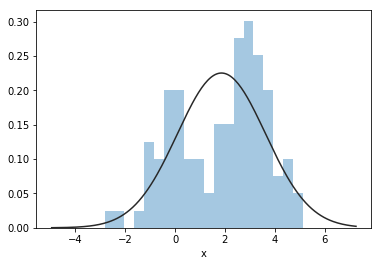

In [50]:
sns.distplot(data,
             fit=scipy.stats.norm,
             bins=20,
             kde=False,);

What model should we fit?
------


X appears to be a mixture of 2 Normal distributions

The New Model
-----

Start with 2 Normal distributions $N(\mu_1, \sigma_1^2)$ and $N(\mu_2, \sigma_2^2)$. 

 

Then mix them…  
$w$ is the probability that the data comes from the first Normal

The model is parameterized as: $\theta = (w, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2)$.

Estimate a probability density function (PDF) is: $f(x | \theta) = w \  f_1(x \ | \  \mu_1, \sigma_1^2) + (1 - w) \  f_2 (x  \ | \  \mu_2, \sigma_2^2) $

There are 5 paramaters: 4 of the them are Normal distributions and 1 more for the probability of choosing one of them.

How can we estimate that model?
-----

Expectation–Maximization (EM)

1. Expectation Step: Given our current best estimate of the model, calculate the how well it fits the data.

2. Maximization Step: Given our data, update our estimated model.

Let's model our data with GMM & EM
-----



In [51]:
class Gaussian:
    "Model univariate Gaussian"

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y

    def __repr__(self):
        return f"Gaussian({self.mu:.4f}, {self.sigma:.4f})"

In [52]:
best_single = Gaussian(np.mean(data), np.std(data))
print(f"Best single Gaussian: μ = {best_single.mu:.2}, σ = {best_single.sigma:.2}")

Best single Gaussian: μ = 1.9, σ = 1.8


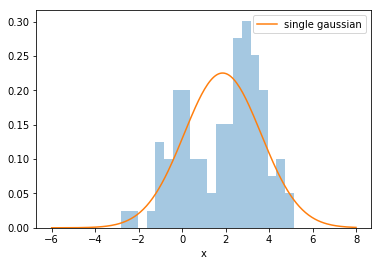

In [53]:
x = np.linspace(-6, 8, 200)
g_single = scipy.stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian'); plt.legend();

In [54]:
from math import sqrt, log, exp, pi
from random import uniform

In [55]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # Compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # Unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # Compute denominator
            den = wp1 + wp2
            # Normalize
            wp1 /= den
            wp2 /= den
            # Add into loglike
            self.loglike += log(wp1 + wp2)
            # Yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # Compute denominators
        (left, right) = zip(*weights)
        one_den = sum(left)
        two_den = sum(right)
        # Compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(right, data))
        # Compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(right, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep())
            if verbose:
#                 print(f'{i} {self}')
                print(self)
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return f"GaussianMixture({self.one}, {self.two}, mix={self.mix:.4f}"

    def __str__(self):
        return f"Mixture: {self.one}, {self.two}, mix={self.mix:.4f}"

HT: https://gist.github.com/kylebgorman/2992206

In [56]:
# Check out the fitting process
n_iterations = 5
best_mix, best_loglike = None, float('-inf')
gmm = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        gmm.iterate(verbose=True)
        if gmm.loglike > best_loglike:
            best_mix, best_loglike = gmm, gmm.loglike
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

Mixture: Gaussian(1.3025, 1.8967), Gaussian(2.4927, 1.3647), mix=0.5292
Mixture: Gaussian(1.2100, 1.8535), Gaussian(2.6048, 1.3251), mix=0.5319
Mixture: Gaussian(1.1187, 1.8186), Gaussian(2.7161, 1.2536), mix=0.5342
Mixture: Gaussian(1.0236, 1.7799), Gaussian(2.8320, 1.1582), mix=0.5359
Mixture: Gaussian(0.9256, 1.7313), Gaussian(2.9482, 1.0470), mix=0.5366


In [57]:
# Find best Mixture Gaussian model
n_iterations, n_random_restarts = 20, 500
best_mix, best_loglike = None, float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    gmm = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            gmm.iterate()
            if gmm.loglike > best_loglike:
                best_mix, best_loglike = gmm, gmm.loglike
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('Done. 🙂')

Computing best model with random restarts...

Done. 🙂


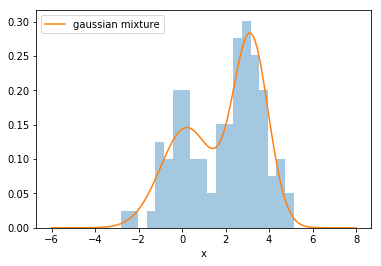

In [58]:
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();

GMM extensions
-----

1. More than 2 Gaussians
1. More than 1 dimensions

GMM extensions: More than 2 Gaussians
-----

<center><img src="images/triples.jpg" width="85%"/></center>

GMM extensions: More than 1 dimensions
-----

<center><img src="http://www.nehalemlabs.net/prototype/wp-content/uploads/2014/02/figure_1-1024x744.png" width="70%"/></center>

Clusters can be assigned based on highest probability
------

<center><img src="http://www.nehalemlabs.net/prototype/wp-content/uploads/2014/04/class-1024x744.png" width="75%"/></center>

Source: http://www.nehalemlabs.net/prototype/blog/2014/04/03/quick-introduction-to-gaussian-mixture-models-with-python/

Summary: Gaussian Mixture Models (GMM)
----

- Gaussian Mixture Models (GMM) assumes the data comes from multiple Gaussians.
- Expectation–Maximization (EM) can be used to estimate paramters of GMM.
- Once a GMM is fit, a data point has a probability of coming from each of the Gaussians.
- For simplicity, take the largest probability as the cluster.

Bonus Material
-----

Beyond GMM with Non-parametric methods: <br> Kernel Density Estimation (KDE)
-----

A non-parametric way to estimate the probability density function of a random variable.

Assume samples are drawn from some distribution with an unknown density ƒ.

Estimate with:
<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/15255412d35488194b7e24e4518765e0af9992b5" width="75%"/></center>

Kernel Density Estimation (KDE)
-----
<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/15255412d35488194b7e24e4518765e0af9992b5" width="75%"/></center>

The only parameter is h the "bandwidth".

It is non-parameter because the number of parameters does not increase with model complexity.

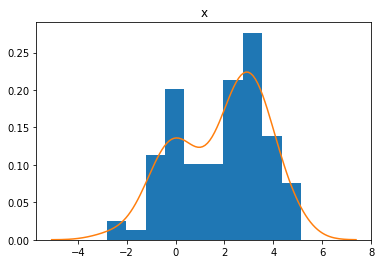

In [59]:
# Our data
df.hist(grid=False, normed=True);
sns.kdeplot(data, legend=False);

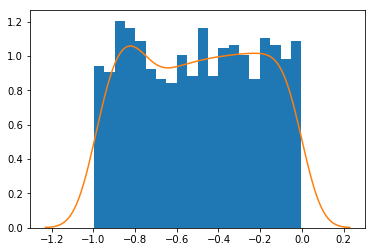

In [60]:
# KDE are flexible to model other distributions
s = np.random.uniform(low=-1, high=0, size=1_000)
plt.hist(s, bins=20, normed=True)
sns.kdeplot(s, legend=False);

In [61]:
# scikit-learn has an implementation

from sklearn.mixture import GaussianMixture

Summary: Gaussian Mixture Models (GMM)
----

- Gaussian Mixture Models (GMM) take our old friend the Gaussian and add another Gaussian(s).
- Which allows us to model more complex data.
- GMM work well but you have to guess/assume the number of Gaussians. Kernel Density Estimation (KDE) does __not__ require that kind of guessing/assumptions
- We fit a GMM with the Expectation–Maximization (EM) Algorithm.